In [ ]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

## Permutation Test

There are several cases where we would like to perform a permuation test in order to test a hypothesis and learn more about the world. A permutation test is a very useful type of non-parametric test that allows us to make inferences without making statistical assumptions that underly traditional parametric tests.

One insightful example of permutation inference is the reexamination of Student Evaluation of Teaching (SET) data by Boring, Ottoboni, and Stark (2016). In this experiment, 47 students were randomly assigned to one of four sections. There are two TAs that teach two sections each; one TA is male and other is female. In two of the sections, the teaching assistants were introduced using their actual names. In the other two sections, the assistants
switched names.

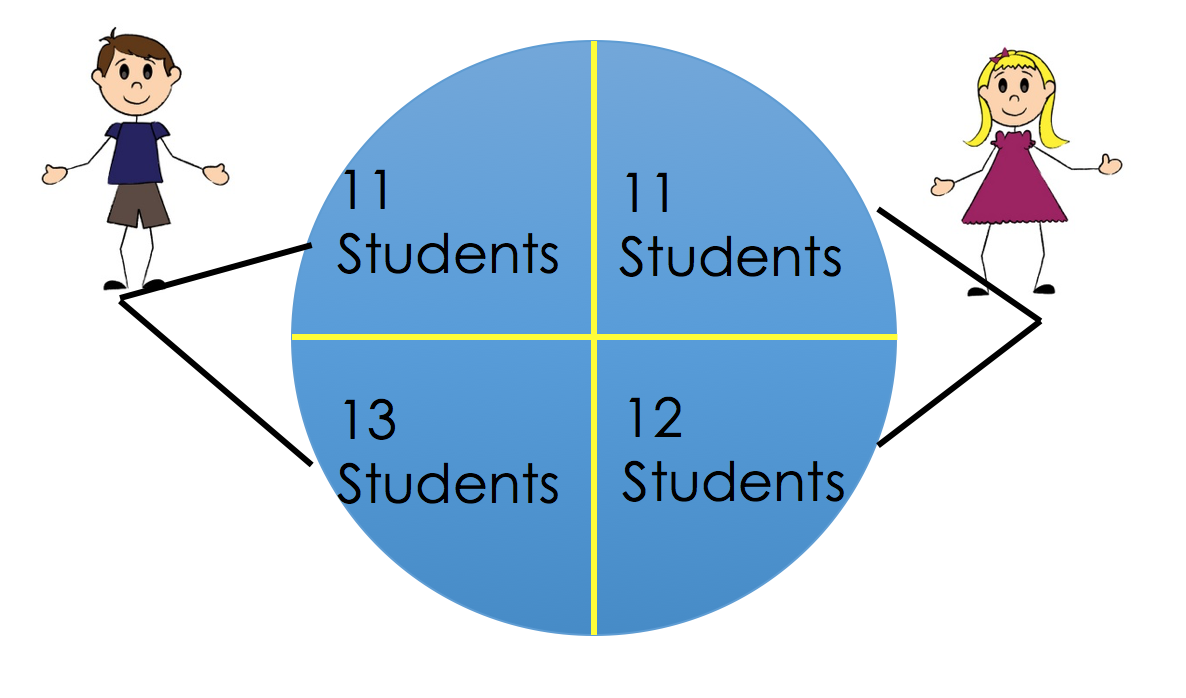

In [3]:
#HIDDEN 
from IPython.display import Image
display(Image('student_setup.png'))

 Students never met the teaching assistants face-to-face. Instead, they interacted with the students via an online forum. Homework returns were coordinated so that all students received scores/feedback all at the same time. The 2 TAs also had comparable levels of experience. At the end of the course, students evaluate the TA on promptness in returning assignment.
The authors wanted to investigate if
gender perception has any effect on SETs evaluations/ratings. 


### Experiment Setup

We conduct a hypothesis test using a p-value cutoff of 0.05.

In our **model**, each TA has two possible ratings from each student—one for each perceived gender. Each student had an equal chance of being assigned to any one of the (gender, perceived gender) pairs. Finally, the students evaluate their TAs independently of one another.

The **null hypothesis** of this experiment is that perceived gender has no effect on SETs and any observed difference in ratings is due to chance. In other words, the evaluation of each TA should remain unchanged whether they are percieved as a male or a female. This means that each TA really only has one possible rating from each student.

The **alternative hypothesis** is that perceived gender has an effect on SETs.

The **test statistic** is the absolute difference in means of perceived male and perceived female ratings for each TA. Intuitively, we expect this to be close to 0 if gender has no effect on ratings. We can write this formally:

$$
\left| \mu_{\text{perceived female}} - \mu_{\text {perceived male}} \right|
$$

Where:

$$
\begin{aligned}
\mu_{\text{perceived female}} &= \frac {\sum_{j=1}^{n_1} x_{1j} + \sum_{j=1}^{n_3} x_{3j}}{{n_1} + {n_3}} \\
\mu_{\text{perceived male}} &= \frac {\sum_{j=1}^{n_2} x_{2j} + \sum_{j=1}^{n_4} x_{4j}}{{n_2} + {n_4}}
\end{aligned}
$$

where $n_i$ is the number of students in the $i$th group and $x_{ij}$ is the rating of the jth student in the ith group. 

In order to determine whether gender has an effect on SET ratings, we perform a permutation test to generate an empirical distribution of the test statistic under the null hypothesis. We follow the following steps:

1. Permute the perceived gender labels for students under the same TA. Note that we are shuffling within the left and right halves in the picture above.
1. Compute the difference in average scores for identified-female and identified-male groups. 
1. Repeat many times to create an approximate sampling distribution for the difference in average scores for the 2 groups. 
1. Use the approximate distribution to estimate the chance of seeing a test statistic more extreme than the one observed.


It is important to understand why the permutation test is justified in this scenario. Under the null model, each student would have given their TA the same rating regardless of perceived gender. Simple random assignment then implies that for a given TA, all of their ratings had an equal chance of showing up regardless of whether they were perceived as male or female. Therefore, permuting the gender labels should have no effect on the ratings if the null hypothesis were true. 

### The Data

We begin with the student and gender data below. These data are a census of 47 students enrolled in an online course at a U.S. university.

In [38]:
#HIDDEN 
student_eval = (
    pd.read_csv('StudentRatingsData.csv')
    .loc[:, ["tagender", "taidgender", "prompt"]]
    .dropna()
    .rename(columns={'tagender': 'actual', 'taidgender': 'perceived'})
)
student_eval[['actual', 'perceived']] = (
    student_eval[['actual', 'perceived']]
    .replace([0, 1], ['female', 'male'])
)
student_eval

,actual,perceived,prompt
0,female,male,4.0
1,female,male,5.0
2,female,male,5.0
...,...,...,...
43,male,female,4.0
44,male,female,2.0
45,male,female,4.0


The columns have the following meanings:

**actual** – the true gender of the TA

**perceived** – the gender presented to the students

**prompt** – rating on promptness of HW on a scale from 1 to 5

After analyzing and plotting the ratings data from the experiment below,  there appears to be a difference between the groups of students, with perceived female ratings lower than male ratings; however, we need a more formal hypothesis test to see if this difference could simply be due to the random assignment of students.

In [48]:
# HIDDEN
avg_ratings = (student_eval
 .loc[:, ['actual', 'perceived', 'prompt']]
 .groupby(['actual', 'perceived'])
 .mean()
 .rename(columns={'prompt': 'mean prompt'})
)
avg_ratings

mean prompt
actual perceived             
female female            3.75
       male              4.33
male   female            3.42
       male              4.36

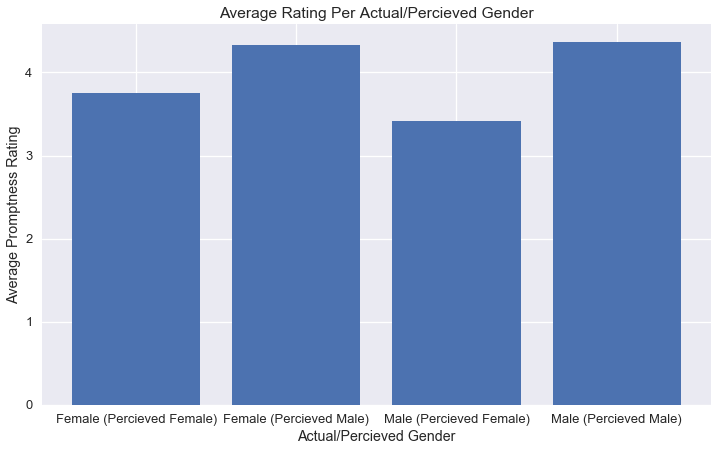

In [49]:
# HIDDEN
fig, ax = plt.subplots(figsize=(12, 7))
ind = np.arange(4)
plt.bar(ind, avg_ratings["mean prompt"])
ax.set_xticks(ind)
ax.set_xticklabels(['Female (Percieved Female)', 'Female (Percieved Male)', 'Male (Percieved Female)', "Male (Percieved Male)"])
ax.set_ylabel('Average Promptness Rating')
ax.set_xlabel('Actual/Percieved Gender')
ax.set_title('Average Rating Per Actual/Percieved Gender')
plt.show()

### Performing the Experiment

We will compute the absolute observed difference between the average ratings of the identified male and identified female groups:

In [146]:
def stat(evals):
    '''Computes the test statistic on the evals DataFrame'''
    avgs = evals.groupby('perceived').mean()
    return np.abs(avgs.loc['female', 'prompt'] - avgs.loc['male', 'prompt'])

In [147]:
observed_difference = stat(student_eval)
observed_difference

0.7978260869565217

We see that the difference is 0.8—in this case, the average rating for those identified as female is nearly 1 point lower on a scale from 1 to 5.  Given the scale of the ratings, this difference appears to be quite large. By performing a permutation test, we will be able to find the chance of observing a difference this large under our null model.

Now, we can permute the perceived gender labels for each TA and calculate the test statistic 1,000 times:

In [148]:
def shuffle_column(df, col):
    '''Returns a new copy of df with col shuffled'''
    result = df.copy()
    result[col] = np.random.choice(df[col], size=len(df[col]))
    return result

In [149]:
repetitions = 1000

gender_differences = np.array([
    stat(shuffle_column(student_eval, 'perceived'))
    for _ in range(repetitions)
])

We plot the approximate sampling distribution of the difference in scores using our permutations below, showing the observed value using a red dotted line. 

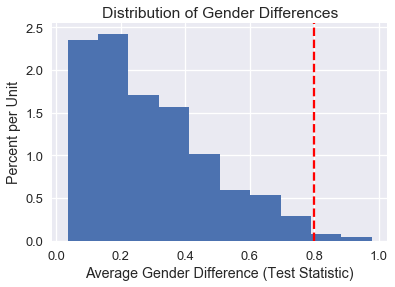

In [150]:
# HIDDEN
differences_df = pd.DataFrame()
differences_df["gender_differences"] = gender_differences
gender_hist = differences_df.loc[:, "gender_differences"].hist(normed=True)
gender_hist.set_xlabel("Average Gender Difference (Test Statistic)")
gender_hist.set_ylabel("Percent per Unit")
gender_hist.set_title("Distribution of Gender Differences")
plt.axvline(observed_difference, c='r', linestyle='--')
plt.legend();

From our calculation below, only 6 of the 1000 simulations had a difference at least as large as the one observed. Therefore, our p-value is less than the 0.05 threshold and we reject the null hypothesis in favor of the alternative.

In [151]:
num_extreme = np.count_nonzero(gender_differences >= observed_difference)
empirical_P = num_extreme / repetitions
empirical_P

0.006

### Conclusion

Through this permuatation test, we have shown that SET are biased against female instructors by an amount that is large and statistically significant.

There are other studies that have also tested bias within teaching evaluations. According to Boring, Ottoboni & Stark 2016, there were several other parametric tests conducted that assumed ratings of male and female instructors are independent random samples from normally distributed populations with equal variances; this type of experimental design does not align with the proposed null hypothesis, causing the p-values to be potentially misleading.

In contrast, Boring, Ottoboni & Stark 2016 used permutation tests based on random assignment of students to class sections. Recall that during our permutation test, we did not make any underlying assumptions about the distribution of our data. In this experiment,  we did not assume that students, SET scores, grades, or any other variables comprise random samples from any populations, much less populations with normal distributions.

When testing a hypothesis, it is very important to carefully choose your experiment design and null hypothesis in order to obtain reliable results.